In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


In [3]:
data=pd.read_csv('Crude Oil Prices Daily.xlsx')

In [4]:
data.head()

,Date,Closing Value
0,02/01/1986,25.56
1,03/01/1986,26.00
2,06/01/1986,26.53
3,07/01/1986,25.85
4,08/01/1986,25.87


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data.shape

(8223, 2)

In [7]:
data_plot=data.iloc[:,1:2].values.astype(float)

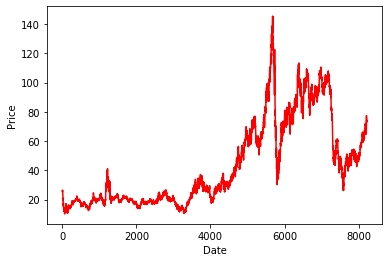

In [8]:
plt.plot(data_plot, color='red', label='Crude Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [9]:
batch_size = 64
epochs = 120
timesteps = 30

In [12]:
w=len(data)
w

8223

In [13]:
w *= 1-0.1
w

7400.7

In [14]:
w%64.0

40.69999999999982

# Batch-size and trainings-set size With stateful LSTMs the trainings-set size must be divisible without remainder by the batch-size (modulo = 0)the below function will help you calculate training set size

In [15]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [17]:
length=get_train_length(data,batch_size,0.2)
length

6528


6528

In [18]:
upper_train= length +timesteps*2
data_train= data[0:upper_train]
train_set= data_train.iloc[:,1:2].values

In [19]:
train_set.shape

(6588, 1)

In [20]:
from sklearn.preprocessing import MinMaxScaler

# scaling between 0 & 1
## to easily find the weight

In [21]:
sc=MinMaxScaler(feature_range=(0,1))
train_set_scaled= sc.fit_transform(np.float64(train_set))
train_set_scaled.shape

(6588, 1)

In [22]:
X_train=[]
Y_train=[]

In [23]:
print(length+timesteps)

6558


In [24]:
for i in range(timesteps,length+timesteps):
    X_train.append(train_set_scaled[i-timesteps:i,0])
    Y_train.append(train_set_scaled[i-timesteps:i,0])

In [25]:
len(X_train)

6528

In [26]:
len(Y_train)

6528

In [27]:
#create X_train matrix
#30 items per array (timestep) 

In [28]:
X_train[0:2]

[array([0.11335703, 0.11661484, 0.12053902, 0.11550422, 0.1156523 ,
        0.11683696, 0.1140234 , 0.10980305, 0.1089886 , 0.11054346,
        0.10165852, 0.09906708, 0.08203761, 0.07670665, 0.07404117,
        0.07167185, 0.06811787, 0.07863172, 0.06811787, 0.06930253,
        0.06908041, 0.06441582, 0.05308752, 0.03946394, 0.04464682,
        0.04701614, 0.05516067, 0.04834888, 0.04464682, 0.0406486 ]),
 array([0.11661484, 0.12053902, 0.11550422, 0.1156523 , 0.11683696,
        0.1140234 , 0.10980305, 0.1089886 , 0.11054346, 0.10165852,
        0.09906708, 0.08203761, 0.07670665, 0.07404117, 0.07167185,
        0.06811787, 0.07863172, 0.06811787, 0.06930253, 0.06908041,
        0.06441582, 0.05308752, 0.03946394, 0.04464682, 0.04701614,
        0.05516067, 0.04834888, 0.04464682, 0.0406486 , 0.04575744])]

In [29]:
np.array(X_train).shape

(6528, 30)

In [30]:
Y_train[0:2]

[array([0.11335703, 0.11661484, 0.12053902, 0.11550422, 0.1156523 ,
        0.11683696, 0.1140234 , 0.10980305, 0.1089886 , 0.11054346,
        0.10165852, 0.09906708, 0.08203761, 0.07670665, 0.07404117,
        0.07167185, 0.06811787, 0.07863172, 0.06811787, 0.06930253,
        0.06908041, 0.06441582, 0.05308752, 0.03946394, 0.04464682,
        0.04701614, 0.05516067, 0.04834888, 0.04464682, 0.0406486 ]),
 array([0.11661484, 0.12053902, 0.11550422, 0.1156523 , 0.11683696,
        0.1140234 , 0.10980305, 0.1089886 , 0.11054346, 0.10165852,
        0.09906708, 0.08203761, 0.07670665, 0.07404117, 0.07167185,
        0.06811787, 0.07863172, 0.06811787, 0.06930253, 0.06908041,
        0.06441582, 0.05308752, 0.03946394, 0.04464682, 0.04701614,
        0.05516067, 0.04834888, 0.04464682, 0.0406486 , 0.04575744])]

In [31]:
np.array(Y_train).shape

(6528, 30)

In [35]:
X_train, y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
Y_train = np.reshape(Y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(Y_train.shape)

(6528, 30, 1)
(6528, 30, 1)


In [40]:
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py
#mae== mean absolute error function

In [41]:
input_1_mae= Input(batch_shape=(batch_size,timesteps,1))

In [42]:
lstm_1_mae = LSTM(10,stateful=True,return_sequences=True)(input_1_mae)
lstm_2_mae = LSTM(10,stateful=True,return_sequences=True)(lstm_1_mae)

In [43]:
output_1_mae=Dense(units=1)(lstm_2_mae)

In [44]:
regressor_mae=Model(inputs=input_1_mae,outputs=output_1_mae)

In [45]:
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_3 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_4 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_2 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [46]:
from keras import backend as K

In [49]:
#1st lstm
parameters=480
parameters

480

In [50]:
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()

Epoch: 0
Epoch 1/1
6528/6528 [==============================] - 6s 967us/step - loss: 0.0242
Epoch: 1
Epoch 1/1
6528/6528 [==============================] - 6s 941us/step - loss: 0.0196
Epoch: 2
Epoch 1/1
6528/6528 [==============================] - 6s 912us/step - loss: 0.0127
Epoch: 3
Epoch 1/1
6528/6528 [==============================] - 6s 904us/step - loss: 0.0139
Epoch: 4
Epoch 1/1
6528/6528 [==============================] - 4s 683us/step - loss: 0.0130
Epoch: 5
Epoch 1/1
6528/6528 [==============================] - 5s 739us/step - loss: 0.0158
Epoch: 6
Epoch 1/1
6528/6528 [==============================] - 5s 709us/step - loss: 0.0113
Epoch: 7
Epoch 1/1
6528/6528 [==============================] - 4s 674us/step - loss: 0.0107
Epoch: 8
Epoch 1/1
6528/6528 [==============================] - 5s 692us/step - loss: 0.0138
Epoch: 9
Epoch 1/1
6528/6528 [==============================] - 5s 690us/step - loss: 0.0111
Epoch: 10
Epoch 1/1
6528/6528 [==============================] - 4s 67

6528/6528 [==============================] - 5s 739us/step - loss: 0.0027
Epoch: 87
Epoch 1/1
6528/6528 [==============================] - 5s 786us/step - loss: 0.0027
Epoch: 88
Epoch 1/1
6528/6528 [==============================] - 5s 757us/step - loss: 0.0019 0s - 
Epoch: 89
Epoch 1/1
6528/6528 [==============================] - 5s 797us/step - loss: 0.0015
Epoch: 90
Epoch 1/1
6528/6528 [==============================] - 6s 862us/step - loss: 0.0018
Epoch: 91
Epoch 1/1
6528/6528 [==============================] - 5s 824us/step - loss: 0.0053
Epoch: 92
Epoch 1/1
6528/6528 [==============================] - 5s 807us/step - loss: 0.0055
Epoch: 93
Epoch 1/1
6528/6528 [==============================] - 6s 861us/step - loss: 0.0020
Epoch: 94
Epoch 1/1
6528/6528 [==============================] - 5s 803us/step - loss: 0.0013
Epoch: 95
Epoch 1/1
6528/6528 [==============================] - 5s 807us/step - loss: 0.0047
Epoch: 96
Epoch 1/1
6528/6528 [==============================] - 5s 767us/

In [92]:
import h5py
regressor_mse.save(filepath='crudeoil_price.h5')
regressor_mse = load_model('crudeoil_price.h5')

In [93]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [94]:
test_length=get_test_length(data,batch_size)
test_length

8060
8124


8124

In [95]:
upper_test=test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

1536


In [96]:
print(upper_train, upper_test, len(data))

6588 8184 8223


In [97]:
data_test=data[upper_train:upper_test]
test_set =data.iloc[:,1:2].values

In [98]:
#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [99]:
X_test.shape

(1536, 30, 1)

In [100]:
predict_bcg_mae= regressor_mae.predict(X_test,batch_size=batch_size)
regressor_mae.reset_states()

In [101]:
predict_bcg_mae.shape

(1536, 30, 1)

In [102]:
predict_bcg_mae = np.reshape(predict_bcg_mae, 
                                       (predict_bcg_mae.shape[0], 
                                        predict_bcg_mae.shape[1]))

In [103]:
predict_bcg_mae.shape

(1536, 30)

In [104]:
predict_bcg_mae = sc.inverse_transform(predict_bcg_mae)


#creating y_test data
Y_test = []
for j in range(0, testset_length - timesteps):
    Y_test = np.append(Y_test, predict_bcg_mae[j, timesteps-1])

# reshaping
Y_test = np.reshape(Y_test, (Y_test.shape[0], 1))

print(Y_test.shape)

(1506, 1)


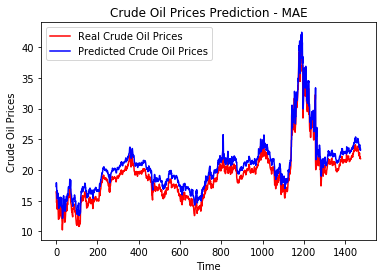

In [105]:
plt.plot(test_set[timesteps:len(Y_test)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(Y_test[0:len(Y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [77]:
#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(Y_test)], Y_test[0:len(Y_test) - timesteps]))
print(rmse)

2851.8633646197964


In [78]:
# Initialising the LSTM Model with MSE Loss Function

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

#mse -> mean squared error as loss function
regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_5 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_6 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_3 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [79]:
epochs = 120
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mse.fit(X_train, Y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mse.reset_states()

Epoch: 0
Epoch 1/1
6528/6528 [==============================] - 6s 929us/step - loss: 0.0028
Epoch: 1
Epoch 1/1
6528/6528 [==============================] - 7s 1ms/step - loss: 0.0017
Epoch: 2
Epoch 1/1
6528/6528 [==============================] - 4s 665us/step - loss: 0.0010
Epoch: 3
Epoch 1/1
6528/6528 [==============================] - 4s 666us/step - loss: 8.3236e-04
Epoch: 4
Epoch 1/1
6528/6528 [==============================] - 4s 658us/step - loss: 7.7131e-04
Epoch: 5
Epoch 1/1
6528/6528 [==============================] - 5s 750us/step - loss: 7.1285e-04 0s - loss: 
Epoch: 6
Epoch 1/1
6528/6528 [==============================] - 4s 670us/step - loss: 6.5871e-04
Epoch: 7
Epoch 1/1
6528/6528 [==============================] - 4s 682us/step - loss: 6.0730e-04
Epoch: 8
Epoch 1/1
6528/6528 [==============================] - 5s 755us/step - loss: 5.6142e-04 1s - l
Epoch: 9
Epoch 1/1
6528/6528 [==============================] - 5s 693us/step - loss: 5.2137e-04
Epoch: 10
Epoch 1/1
6528/

6528/6528 [==============================] - 5s 751us/step - loss: 7.8612e-05
Epoch: 83
Epoch 1/1
6528/6528 [==============================] - 5s 767us/step - loss: 9.4245e-05
Epoch: 84
Epoch 1/1
6528/6528 [==============================] - 5s 762us/step - loss: 7.5546e-05
Epoch: 85
Epoch 1/1
6528/6528 [==============================] - 5s 775us/step - loss: 9.1589e-05
Epoch: 86
Epoch 1/1
6528/6528 [==============================] - 5s 754us/step - loss: 7.3817e-05
Epoch: 87
Epoch 1/1
6528/6528 [==============================] - 5s 776us/step - loss: 8.9589e-05
Epoch: 88
Epoch 1/1
6528/6528 [==============================] - 5s 757us/step - loss: 7.2279e-05
Epoch: 89
Epoch 1/1
6528/6528 [==============================] - 6s 871us/step - loss: 8.7030e-05
Epoch: 90
Epoch 1/1
6528/6528 [==============================] - 5s 777us/step - loss: 7.0150e-05
Epoch: 91
Epoch 1/1
6528/6528 [==============================] - 5s 795us/step - loss: 8.3657e-05
Epoch: 92
Epoch 1/1
6528/6528 [=========

In [82]:
import h5py
regressor_mse.save(filepath='crudeoil_price.h5')

In [84]:
regressor_mse = load_model('crudeoil_price.h5')

In [85]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

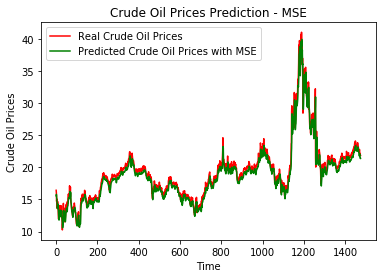

In [86]:
plt.plot(test_set[timesteps:len(pred_mse)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(pred_mse[0:len(pred_mse) - timesteps], color = 'green', label = 'Predicted Crude Oil Prices with MSE')
plt.title('Crude Oil Prices Prediction - MSE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps]))
print(rmse)

0.8853304792181488


In [88]:
mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print(mean)

19.287005420054204


In [89]:
rmse/mean * 100

4.590295175100649

In [90]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps])
print(mae)


0.6609097378686838


In [91]:
mae/mean * 100

3.426709971167864